## Импорт

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
!pip install -q seaborn
np.set_printoptions(precision=3, suppress=True)

%matplotlib inline


##Загрузка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_norm.csv', index_col=0)


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
print(tf.__version__)

2.8.2


## Разделение выборки на train и test

In [ ]:
train_dataset = df.sample(frac=0.7, random_state=42)
test_dataset = df.drop(train_dataset.index)

## Отделим целевое значение от входящих

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Прочность при растяжении. МПа')
test_labels = test_features.pop('Прочность при растяжении. МПа')

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Прочность при растяжении. МПа,0.508302,0.164622
Соотношение матрица-наполнитель,0.486475,0.169407
Количество отвердителя. м.%,0.509151,0.151012
Содержание эпоксидных групп.%_2,0.423179,0.127015
Потребление смолы. г/м2,0.479778,0.152716
Угол нашивки. град,0.497710,0.500377
Шаг нашивки,0.479948,0.174186
Плотность нашивки,0.551918,0.109145
модуль упругости. ГПа,0.388002,0.175565
Плотность. кг/м3,0.506082,0.149064


## Нормализуем входящие значения

In [ ]:
#Создаем слой нормализации
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
#Препроцессинг данных
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[[0.486 0.509 0.423 0.48  0.498 0.48  0.552 0.388 0.506 0.598 0.347 0.499]]


In [ ]:
df.describe()


,Прочность при растяжении. МПа,Соотношение матрица-наполнитель,Количество отвердителя. м.%,Содержание эпоксидных групп.%_2,Потребление смолы. г/м2,Угол нашивки. град,Шаг нашивки,Плотность нашивки,модуль упругости. ГПа,Плотность. кг/м3,Температура вспышки. С_2,Поверхностная плотность. г/м2,Модуль упругости при растяжении. ГПа
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,0.508836,0.487527,0.514179,0.424329,0.482711,0.511752,0.478901,0.552481,0.385423,0.508972,0.593860,0.344826,0.496622
std,0.164974,0.171790,0.149205,0.127760,0.151862,0.500129,0.173794,0.108082,0.172180,0.148754,0.125771,0.200288,0.163055
min,0.075949,0.030369,0.115490,0.076869,0.078476,0.000000,0.002606,0.262268,0.000000,0.110749,0.253371,0.000000,0.080485
25%,0.394824,0.371473,0.412683,0.336971,0.382591,0.000000,0.355596,0.482837,0.259882,0.402680,0.508133,0.189716,0.386234
50%,0.505446,0.483499,0.515266,0.423031,0.484747,1.000000,0.480823,0.553754,0.385679,0.515733,0.593808,0.326768,0.494158
75%,0.611156,0.606890,0.619499,0.517835,0.584561,1.000000,0.594954,0.623126,0.500750,0.605859,0.679890,0.497018,0.604291
max,0.949223,0.946640,0.905499,0.784214,0.854149,1.000000,0.950963,0.827131,0.862699,0.902926,0.913158,0.922654,0.932095


Когда мы вызываем слой нормализации, он выдает массив, где каждая переменная нормализована независимо от других

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[0.48 0.5  0.37 0.44 0.   0.75 0.68 0.35 0.61 0.59 0.38 0.74]]

Normalized: [[-0.06 -0.03 -0.44 -0.24 -1.    1.54  1.18 -0.21  0.69 -0.1   0.17  1.45]]


##Линейная регрессия для одной переменной. 
Попробуем предсказать прочность при растяжении в зависимости от количества отвердителя

Сначала создадим NumPy array, состоящий из значений "Количество отвердителя". Затем сопоставим ему tf.keras.layers.Normalization

In [ ]:
hardener = np.array(train_features['Количество отвердителя. м.%'])

hardener_normalizer = layers.Normalization(input_shape=[1,], axis=None)
hardener_normalizer.adapt(hardener)

Строим  Keras Sequential модель

In [ ]:
hardener_model = tf.keras.Sequential([
    hardener_normalizer,
    layers.Dense(units=1)
])

hardener_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Модель предскажет  'Прочность при растяжении' от 'Количества отвердителя'.

Запустим необученную модель на 10 значениях 'Количества отвердителя'. Результат будет неудовлетворительный, но мы проверим формат (10, 1):

In [ ]:
hardener_model.predict(hardener[:10])

array([[-0.021],
       [-0.489],
       [ 0.448],
       [-0.194],
       [-0.921],
       [-0.259],
       [-0.042],
       [-0.205],
       [ 1.676],
       [ 0.572]], dtype=float32)

Модель построена, сконфигурируем обучение методом Keras Model.compile method. Наиболее важные параметры - loss и optimizer. Выбрали, что именно будем оптимизировать ('mean_absolute_error') и как (оптимайзер tf.keras.optimizers.Adam).

In [ ]:
hardener_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

Используем Keras Model.fit чтобы провести обучение за 25 эпох:

In [ ]:
%%time
history = hardener_model.fit(
    train_features['Количество отвердителя. м.%'],
    train_labels,
    epochs=25,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 30% of the training data.
    validation_split = 0.5)

CPU times: user 2.14 s, sys: 114 ms, total: 2.25 s
Wall time: 3.06 s


## Визуализируем процесс обучения через отображение состояний, сохраненных в  history object:

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
20,0.132344,0.129535,20
21,0.131773,0.130614,21
22,0.132365,0.130691,22
23,0.131568,0.129827,23
24,0.131914,0.130819,24


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Прочность при растяжении. МПа]')
  plt.legend()
  plt.grid(True)

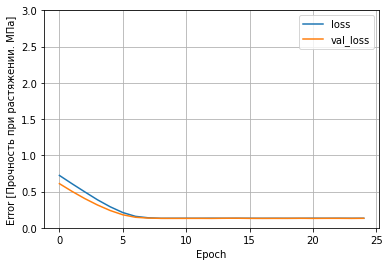

In [ ]:
plot_loss(history)

Соберем данные тестового набора для использования в дальнейшем

In [ ]:
test_results = {}

test_results['Линейная регрессия'] = hardener_model.evaluate(
    test_features['Количество отвердителя. м.%'],
    test_labels, verbose=0)

Отобразим график линейной регрессии

In [ ]:
x = tf.linspace(0.0, 2, 2)
y = hardener_model.predict(x)

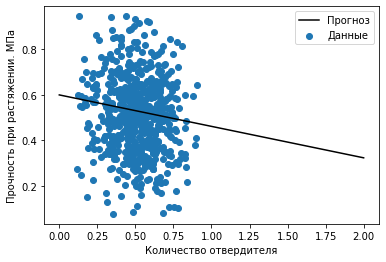

In [ ]:
def plot_hardener(x, y):
 plt.scatter(train_features['Количество отвердителя. м.%'], train_labels, label='Данные')
 plt.plot(x, y, color='k', label='Прогноз')
 plt.xlabel('Количество отвердителя')
 plt.ylabel('Прочность при растяжении. МПа')
 plt.legend()
plot_hardener(x, y)

## Линейная регрессия для нескольких переменных
Эта модель  выполняет обычное  y = mx + b, только  m - это матрица, а b - вектор.

Создаем двухэтапную последовательную модель Keras с первым слоем, являющимся нормализатором tf.keras, которую мы определили ранее и адаптировали ко всему набору данных

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Вызываем Model.predict на входных данных. Она производит units=1 результат для каждого примера:

In [ ]:
linear_model.predict(train_features[:10])

array([[-0.343],
       [ 0.099],
       [ 0.948],
       [ 0.415],
       [-0.208],
       [-1.438],
       [ 0.304],
       [-0.249],
       [ 0.841],
       [-0.114]], dtype=float32)

При вызове модели будут построены ее весовые матрицы — убедимся, что веса ядра (m в y = mx + b) имеют размер (9, 1):

In [ ]:
linear_model.layers[1].kernel

<tf.Variable 'dense_29/kernel:0' shape=(12, 1) dtype=float32, numpy=
array([[-0.423],
       [ 0.224],
       [ 0.081],
       [ 0.395],
       [ 0.378],
       [-0.147],
       [-0.315],
       [ 0.231],
       [ 0.243],
       [-0.064],
       [ 0.209],
       [ 0.401]], dtype=float32)>

Настройте модель с помощью Keras Model.compile и обучим с помощью Model.fit для 20 эпох

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2.5 s, sys: 103 ms, total: 2.6 s
Wall time: 3.86 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
15,0.165807,0.160312,15
16,0.174350,0.185679,16
17,0.190825,0.216519,17
18,0.198589,0.188654,18
19,0.187314,0.211552,19


## Визуализируем ход обучения модели, используя статистику, хранящуюся в объекте history

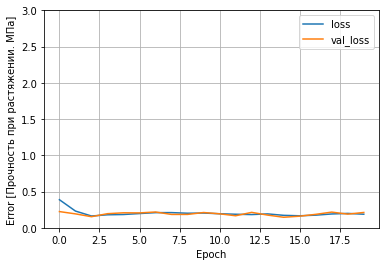

In [ ]:
plot_loss(history)

In [ ]:
test_results['Линейная модель для нескольких переменных'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Регрессия с использованием нейросети

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(32, activation='linear'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
# def build_and_compile_model(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(128, activation='relu'),
#       layers.Dense(64, activation='relu'),
#       layers.Dropout(0.2),
#       layers.Dense(32, activation='linear'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model

Регрессия с использованием нейросети для одной переменной

In [ ]:
dnn_hardener_model = build_and_compile_model(hardener_normalizer)

In [ ]:
dnn_hardener_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_30 (Dense)            (None, 128)               256       
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
%%time
history = dnn_hardener_model.fit(
    train_features['Количество отвердителя. м.%'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 3.18 s, sys: 139 ms, total: 3.32 s
Wall time: 4.34 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
15,0.137770,0.123619,15
16,0.136680,0.121395,16
17,0.135748,0.120759,17
18,0.134162,0.121609,18
19,0.138072,0.121575,19


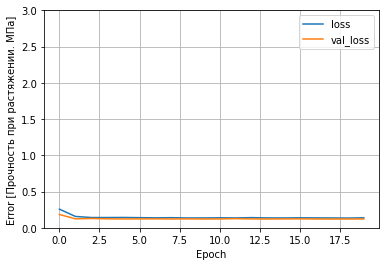

In [ ]:
plot_loss(history)

Смотрим график

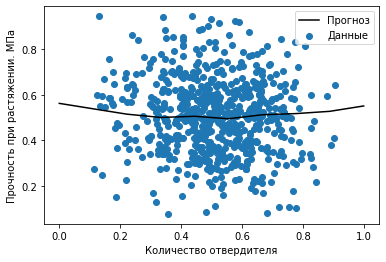

In [ ]:
x = tf.linspace(0.0, 1, 10)
y = dnn_hardener_model.predict(x)
plot_hardener(x, y)

Забавно получилось)))

In [ ]:
#Сохраняем данные на будущее
test_results['Нейросеть для одной переменной'] = dnn_hardener_model.evaluate(
    test_features['Количество отвердителя. м.%'], test_labels,
    verbose=0)

## НЕЙРОСЕТЬ ДЛЯ МНОЖЕСТВЕННОЙ РЕГРЕССИИ

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_34 (Dense)            (None, 128)               1664      
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

CPU times: user 3.54 s, sys: 135 ms, total: 3.67 s
Wall time: 6.22 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
15,0.105158,0.140936,15
16,0.099299,0.139388,16
17,0.098684,0.140081,17
18,0.091781,0.138608,18
19,0.090700,0.141243,19


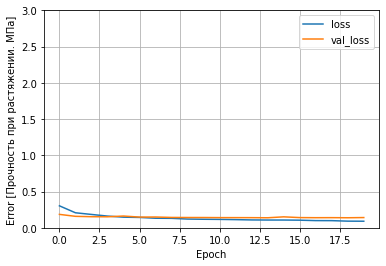

In [ ]:
plot_loss(history)

In [ ]:
#Соберем результаты
test_results['Нейросеть для множественной регрессии'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Представление работы обученной модели на тестовой выборке


In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [Прочность при растяжении. МПа]']).T

,Mean absolute error [Прочность при растяжении. МПа]
Линейная регрессия,0.134628
Линейная модель для нескольких переменных,0.178289
Нейросеть для одной переменной,0.130647
Нейросеть для множественной регрессии,0.145080



Эти результаты соответствуют ошибке валидации на тестовых данных

## Сделаем прогноз

Прогноз считаем по нейросети с использованием Keras Model.predict и отслеживаем ошибку

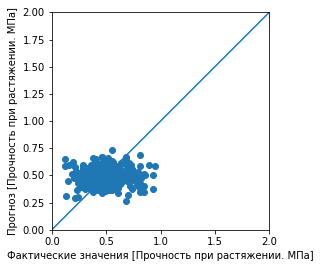

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('Фактические значения [Прочность при растяжении. МПа]')
plt.ylabel('Прогноз [Прочность при растяжении. МПа]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

НС предсказывает не очень хорошо.

Посмотрим распределение ошибки:

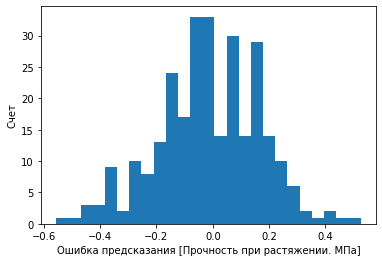

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Ошибка предсказания [Прочность при растяжении. МПа]')
_ = plt.ylabel('Счет')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Прочность при растяжении. МПа')
test_labels = test_features.pop('Прочность при растяжении. МПа')

##Поиск гиперпараметров по сетке с перекрестной проверкой GridSearchCV, количество блоков равно 10

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
dec_tree = RandomForestRegressor()
dec_tree.fit(train_features, train_labels)

np.random.seed(42)

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 4]
             }

grid_search = GridSearchCV(estimator=dec_tree, 
                           param_grid=param_grid, cv=10, verbose=True)
grid_search.fit(train_features, train_labels)

best_dec_tree = grid_search.best_estimator_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [ ]:
best_dec_tree

RandomForestRegressor(ccp_alpha=0.01, max_depth=2)

In [ ]:
y_pred = best_dec_tree.predict(test_features)

In [ ]:
R2 = best_dec_tree.score(test_features, test_labels)
MSE = mean_squared_error (test_labels,y_pred)
MAE = mean_absolute_error (test_labels,y_pred)
print(f'R2: {R2}\nMSE: {MSE}\nMAE: {MAE}')

R2: -0.00015261807453681442
MSE: 0.02748876213904787
MAE: 0.13122688304408742


Сохраним модель 

In [ ]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
import pickle

In [ ]:
pickle.dump(dnn_model, open('dnn_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://43426155-374b-4539-a174-fd985e1fcf57/assets


In [ ]:
model_load=pickle.load(open('dnn_model.pkl', 'rb'))
train_features=[1050365]
model_load.predict(train_features)

array([[162174.27]], dtype=float32)